# Постановка задачи

Провести прогнозирование энергопотребления предприятия на основе исторических данных о потреблении. Данная задача будет решена с помощью применения моделей машинного обучения и библиотек для анализа и прогнозирования временных рядов. В результате будет приведена таблица с получившейся оценкой для каждой модели и даны рекомендации по прогнозированию временных рядов.

# Импорт необходимых библиотек

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 71 kB/s 


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time
import warnings
import numpy as np
import seaborn as sns 
import lightgbm as lgb
from itertools import cycle
from sklearn.svm import SVR
import statsmodels.api as sm
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import plotly.express as px
import lightgbm as lgb
#from catboost import CatBoostRegressor
from collections import defaultdict
from statsmodels.tsa.stattools import adfuller


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Подгрузка данных

Входной датасет содержит данные о почасовом энергопотреблении за три месяца 

In [ ]:
# загрузка данных
data = pd.read_excel('Neftebaza.xlsx')
data.head(5)

,Дата,часы,Потребитель
0,2022-01-01,1,38.4
1,2022-01-01,2,40.5
2,2022-01-01,3,40.2
3,2022-01-01,4,36.6
4,2022-01-01,5,39.9


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Дата         2160 non-null   datetime64[ns]
 1   часы         2160 non-null   int64         
 2   Потребитель  2160 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 50.8 KB


Создадим новую колонку, в которой будет содержаться информация о дне и часе

In [ ]:
# заменим 24 на 0 в колонке часы
# создадим функцию
def mod_midnight(t):
    if t == 24:
        t = 0
    return t

# применим функцию
data['часы'] = data['часы'].apply(mod_midnight)

# преобразуем значения колонок 'Дата', 'часы' в строку
data['Дата'] = data['Дата'].astype(str)
data['часы'] = data['часы'].astype(str)

# создадим новую колонку 
data['date'] = data['Дата'] + "-" + data['часы']
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d-%H')

In [ ]:
data.head()

,Дата,часы,Потребитель,date
0,2022-01-01,1,38.4,2022-01-01 01:00:00
1,2022-01-01,2,40.5,2022-01-01 02:00:00
2,2022-01-01,3,40.2,2022-01-01 03:00:00
3,2022-01-01,4,36.6,2022-01-01 04:00:00
4,2022-01-01,5,39.9,2022-01-01 05:00:00


In [ ]:
# возьмем необходимые колонки для дальнейшей работы
data_clean = data[['date', 'Потребитель']]

In [ ]:
data_clean.head()

,date,Потребитель
0,2022-01-01 01:00:00,38.4
1,2022-01-01 02:00:00,40.5
2,2022-01-01 03:00:00,40.2
3,2022-01-01 04:00:00,36.6
4,2022-01-01 05:00:00,39.9


In [ ]:
# сохраним преобразованный датасет
data_clean.to_excel("data_clean.xlsx", index=False)

# EDA

Построим график потребления, для визуальной оценки.

In [ ]:
fig = px.line(x=data_clean['date'], y=data_clean['Потребитель'], labels={'x':'Время', 'y':'Потребление'}, width=800, height=400)
fig.show()

Преобразуем датасет добавив в отдельную колонку данные о часе и дне недели для удобства дальнейшего анализа

In [ ]:
data_clean["hour"] = data_clean['date'].apply(lambda x: x.hour)
data_clean["weekday"] = data_clean['date'].apply(lambda x: x.weekday())

Посмотрим как выглядят наши данные теперь

In [ ]:
data_clean.head()

,date,Потребитель,hour,weekday
0,2022-01-01 01:00:00,38.4,1,5
1,2022-01-01 02:00:00,40.5,2,5
2,2022-01-01 03:00:00,40.2,3,5
3,2022-01-01 04:00:00,36.6,4,5
4,2022-01-01 05:00:00,39.9,5,5


In [ ]:
fig = px.box(data_clean, x="hour", y="Потребитель", title = 'Графики boxplot Для каждого часа за три месяца')
fig.show()

In [ ]:
fig = px.box(data_clean, x="weekday", y="Потребитель", title = 'Графики boxplot Для каждого дня недели')
fig.show()

Так как прогнозировать можно только временной ряд который является стацоннарным, была проведена проверка на стационнарность с помощью теста Дики Фуллера

In [ ]:
test = adfuller(data_clean['Потребитель'])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('Ряд стационарен')

adf:  -4.669114100794021
p-value:  9.61438185748442e-05
Critical values:  {'1%': -3.4334165947172752, '5%': -2.8628947034764844, '10%': -2.5674911783095395}
Ряд стационарен


График автокорреляции

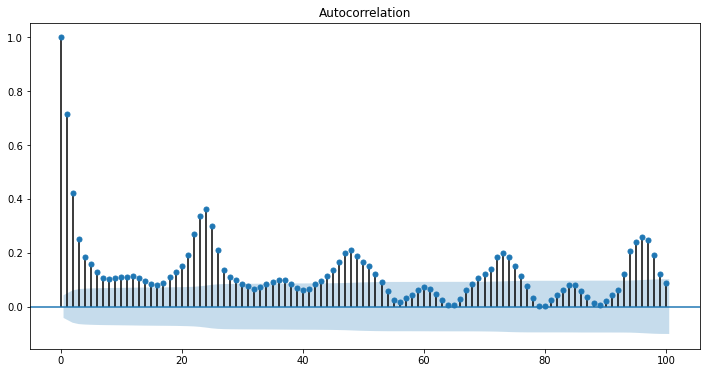

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(data_clean['Потребитель'], ax=ax, lags=100)
plt.show()

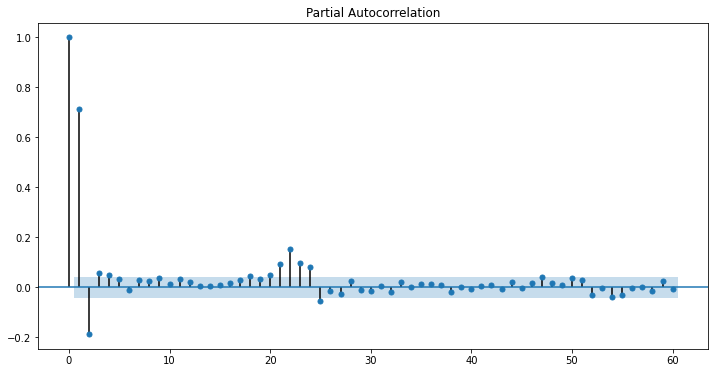

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(data_clean['Потребитель'], ax=ax, lags=60)
plt.show()

Комментарий по автокорреляции и частичной: Если правильно интерпретирую, то можно сказать что ряд имеет дневную и 1-у часовую сезонность.

# Применение различных моделей машинного обучения для прогнозирования временного ряда

## Feature engineering

Для прогнозирования временного ряда с помощью моделей машинного обучения необходимо добавить признаки по которым модель может обучаться и делать прогноз. В данном разделе будут созданы признаки (фичи) для дальнейшего использования в моделях.

In [ ]:
# загрузка данных
data = pd.read_excel('data_clean.xlsx')
data.head()

,date,Потребитель
0,2022-01-01 01:00:00,38.4
1,2022-01-01 02:00:00,40.5
2,2022-01-01 03:00:00,40.2
3,2022-01-01 04:00:00,36.6
4,2022-01-01 05:00:00,39.9


Добавим в качестве предиктров данные о времени и дне недели

In [ ]:
data["hour"] = data['date'].apply(lambda x: x.hour)
data["weekday"] = data['date'].apply(lambda x: x.weekday())

In [ ]:
data.head()

,date,Потребитель,hour,weekday
0,2022-01-01 01:00:00,38.4,1,5
1,2022-01-01 02:00:00,40.5,2,5
2,2022-01-01 03:00:00,40.2,3,5
3,2022-01-01 04:00:00,36.6,4,5
4,2022-01-01 05:00:00,39.9,5,5


Далее создадим функцию которая возвращает lag(24) lag(1) и скользящее среднее 3 и 8. Выбор лагов заключался из предположения что 24 и 1 час назад было такое же потребление. Выбор скользящего среднего выбирался субъективно.

In [ ]:

def lags_windows(df):
    lags = [24]
    lag_cols = ["lag_{}".format(lag) for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df["Потребитель"].shift(lag)

    wins = [8]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            df["rmean_{}_{}".format(lag,win)] = df[lag_col].transform(lambda x : x.rolling(win).mean())   
    return df

def feat_eng(df):
    df = lags_windows(df)
    return df

In [ ]:
def lags_windows_1(df):
    lags = [1]
    lag_cols = ["lag_{}".format(lag) for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df["Потребитель"].shift(lag)

    wins = [3]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            df["rmean_{}_{}".format(lag,win)] = df[lag_col].transform(lambda x : x.rolling(win).mean())   
    return df

def feat_eng_1(df):
    df = lags_windows_1(df)
    return df

Посмотрим на результат работы функции

In [ ]:
data_example = data
feat_eng(feat_eng_1(data_example))

,date,Потребитель,hour,weekday,lag_1,rmean_1_3,lag_24,rmean_24_8
0,2022-01-01 01:00:00,38.4,1,5,NaN,NaN,NaN,NaN
1,2022-01-01 02:00:00,40.5,2,5,38.4,NaN,NaN,NaN
2,2022-01-01 03:00:00,40.2,3,5,40.5,NaN,NaN,NaN
3,2022-01-01 04:00:00,36.6,4,5,40.2,39.700000,NaN,NaN
4,2022-01-01 05:00:00,39.9,5,5,36.6,39.100000,NaN,NaN
...,...,...,...,...,...,...,...,...
2155,2022-03-31 20:00:00,55.3,20,3,34.4,36.866667,126.4,61.0375
2156,2022-03-31 21:00:00,59.0,21,3,55.3,42.300000,47.8,63.1625
2157,2022-03-31 22:00:00,60.1,22,3,59.0,49.566667,36.9,63.3500
2158,2022-03-31 23:00:00,60.4,23,3,60.1,58.133333,36.6,62.9625


По итогу получили 6 фичей по которым можно построить модели машинного обучения

## Модели машинного обучения

Далее будет произведен прогноз временного ряда с помощью различных моделей машинного обучения. Прогнозирование будет осуществляться на неделю вперёд.

### Linear Regression

Сразу разобъем наши данные на тренировочную и тестовую выборку

In [ ]:
data = pd.read_excel('data_clean.xlsx')
data["hour"] = data['date'].apply(lambda x: x.hour)
data["weekday"] = data['date'].apply(lambda x: x.weekday())

train, test = train_test_split(data, train_size = 1 - 24/len(data), shuffle=False)

#### old code

In [ ]:
# старый код
start_time = time.time()
temp = train.copy()
y_test = test.copy()
y_test = y_test['Потребитель']
pred_lr = y_test.copy()

for i in range(len(test)):

  temp_4_fit = temp.copy()
  temp_4_fit = feat_eng(feat_eng_1(temp_4_fit))
  temp_4_fit = temp_4_fit.dropna()

  X_train_4_fit = temp_4_fit.drop(['Потребитель', 'date'], axis = 1)
  y_train_4_fit = temp_4_fit['Потребитель']

  lr = LinearRegression()
  lr.fit(X_train_4_fit, y_train_4_fit)

  temp.loc[test.index[i]] = test.iloc[i]
  temp_4_pred = temp.copy()
  temp_4_pred.loc[test.index[i], 'Потребитель'] = np.nan
  temp_4_pred = feat_eng(feat_eng_1(temp_4_pred))

  temp_4_pred = temp_4_pred.tail(1)
  X_train_4_pred = temp_4_pred.drop(['Потребитель', 'date'], axis = 1)
  X_train_4_pred = X_train_4_pred.fillna(0)

  fitted = lr.predict(X_train_4_pred)
  pred_lr.loc[pred_lr.index[i]] = float(fitted)
  
time_lr = time.time() - start_time

#### new code

In [ ]:
# новый код
start_time = time.time()
temp = train.copy()
temp_4_pred = temp.copy()
front_predict = len(test)
for i in range(front_predict):
# добавили фичи
  temp_4_fit = temp.copy()
  temp_4_fit = feat_eng(feat_eng_1(temp_4_fit))
  temp_4_fit = temp_4_fit.dropna()
  temp_4_fit = temp_4_fit.reset_index(drop=True)
# подготовили иксы и игрики для модели
  X_train_4_fit = temp_4_fit.drop(['Потребитель', 'date'], axis = 1)
  y_train_4_fit = temp_4_fit['Потребитель']
# протренировали модель
  lr = LinearRegression()
  lr.fit(X_train_4_fit, y_train_4_fit)
# создаём следуюущее значение которое надо предсказать
# создадим новую строку, в основном, надо чтобы была добавлена дата на час вперед, остальные знаения будут в нуле
   
  temp_4_pred.loc[len(temp_4_pred), 'date'] = temp_4_pred['date'].iloc[-1] + timedelta(hours=1)
  temp_4_pred.loc[len(temp_4_pred), 'Потребитель'] = np.nan
  temp_4_pred = feat_eng(feat_eng_1(temp_4_pred))
  temp_4_pred = temp_4_pred[:-1]
# на данном этапе имеем датафрейм с одной добавленной строкой и одни пустым значением в искомом столбце
# выделим строку для предсказания
  value_4_pred = temp_4_pred.tail(1)
  X_train_4_pred = value_4_pred.drop(['Потребитель', 'date'], axis = 1)
  X_train_4_pred = X_train_4_pred.fillna(0)
# предсказываем значение
  predict_consumer = lr.predict(X_train_4_pred)
  temp_4_pred.loc[len(temp_4_pred)-1, 'Потребитель'] = float(predict_consumer)
  temp = temp_4_pred.copy()
final = temp_4_pred.copy()  
final = temp_4_pred.copy().loc[len(final)-front_predict:][['date', 'Потребитель']]
time_lr = time.time() - start_time

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Text(0.5, 1.0, 'Linear regression')

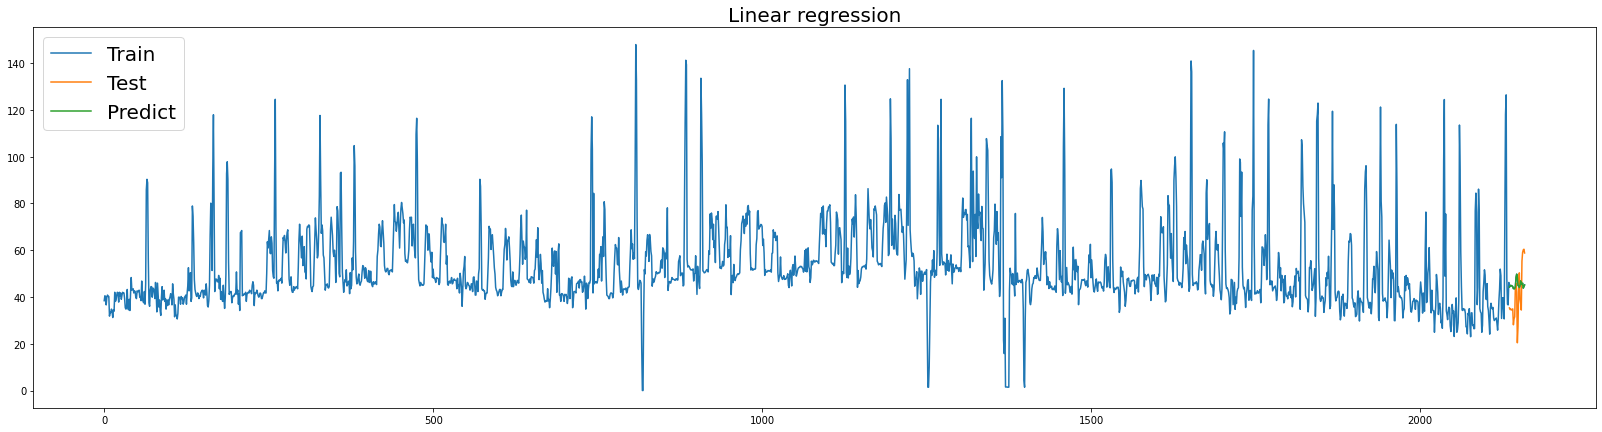

In [ ]:
plt.subplots(figsize=(28,7))
plt.plot(temp['Потребитель'].to_frame(), label = 'Train')
plt.plot(test['Потребитель'].to_frame(), label = 'Test')
plt.plot(final_lgbm['Потребитель'].to_frame(), label = 'Predict')

plt.legend(loc='upper left', fontsize=20)
plt.title("Linear regression", fontsize=20)

Будем заполнять датафрейм для сравнения моделей

In [ ]:
y_test = test['Потребитель']
pred_lr = final_lgbm['Потребитель']
df_rmse_rrmse = pd.DataFrame(data = {'Модель' : 'Linear Regression', 'RMSE' :
                                     [round(mean_squared_error(y_test, pred_lr, squared=False), 1)],
                                      'MAE' : [round(mean_absolute_error(y_test, pred_lr), 1)] ,
                                      'Промежуток прогнозирования' : 'Неделя', 'Дискретность' : 'Часы',
                                      "Время выполнения, c": [round(time_lr, 2)]})

In [ ]:
df_rmse_rrmse

,Модель,RMSE,MAE,Промежуток прогнозирования,Дискретность,"Время выполнения, c"
0,Linear Regression,12.2,10.7,Неделя,Часы,0.47


### RandomForest

Далее представлена "функция" которая вдобавок к прогнозированию подбирает гиперпараметры и производит перекрестную проверку.

In [ ]:
start_time = time.time()
temp = train.copy()
y_test = test.copy()
y_test = y_test['Потребитель']
pred_rf = y_test.copy()
params = {'n_estimators' : list(range(50,105,5)), 'max_depth' : list(range(5,11)), 'min_samples_split' : list(range(2,6)), 'min_samples_leaf' : list(range(1,6))}

temp_4_fit = temp.copy()
temp_4_fit = feat_eng(feat_eng_1(temp_4_fit))
temp_4_fit = temp_4_fit.dropna()
X_train_4_fit = temp_4_fit.drop(['Потребитель', 'date'], axis = 1)
y_train_4_fit = temp_4_fit['Потребитель']

rf = RandomForestRegressor()

gs_reg = GridSearchCV(rf, params, cv = TimeSeriesSplit(n_splits=4).split(X_train_4_fit))
gs_reg.fit(X_train_4_fit, y_train_4_fit)
best_rf = gs_reg.best_estimator_

temp.loc[test.index[0]] = test.iloc[0]
temp_4_pred = temp.copy()
temp_4_pred.loc[test.index[0], 'Потребитель'] = np.nan
temp_4_pred = feat_eng(feat_eng_1(temp_4_pred))

temp_4_pred = temp_4_pred.tail(1)
X_train_4_pred = temp_4_pred.drop(['Потребитель', 'date'], axis = 1)

fitted = best_rf.predict(X_train_4_pred)
pred_rf.loc[pred_rf.index[0]] = float(fitted)

for i in range(1,len(test)):

  temp_4_fit = temp.copy()
  temp_4_fit = feat_eng(feat_eng_1(temp_4_fit))
  temp_4_fit = temp_4_fit.dropna()

  X_train_4_fit = temp_4_fit.drop(['Потребитель', 'date'], axis = 1)
  y_train_4_fit = temp_4_fit['Потребитель']

  best_rf.fit(X_train_4_fit, y_train_4_fit)

  temp.loc[test.index[i]] = test.iloc[i]
  temp_4_pred = temp.copy()
  temp_4_pred.loc[test.index[i], 'Потребитель'] = np.nan
  temp_4_pred = feat_eng(feat_eng_1(temp_4_pred))

  temp_4_pred = temp_4_pred.tail(1)
  X_train_4_pred = temp_4_pred.drop(['Потребитель', 'date'], axis = 1)
  X_train_4_pred = X_train_4_pred.fillna(0)

  fitted = best_rf.predict(X_train_4_pred)
  pred_rf.loc[pred_rf.index[i]] = float(fitted)
time_rf = time.time() - start_time

In [ ]:
best_rf

RandomForestRegressor(max_depth=7, min_samples_leaf=3, min_samples_split=5,
                      n_estimators=55)

Text(0.5, 1.0, 'Random forest')

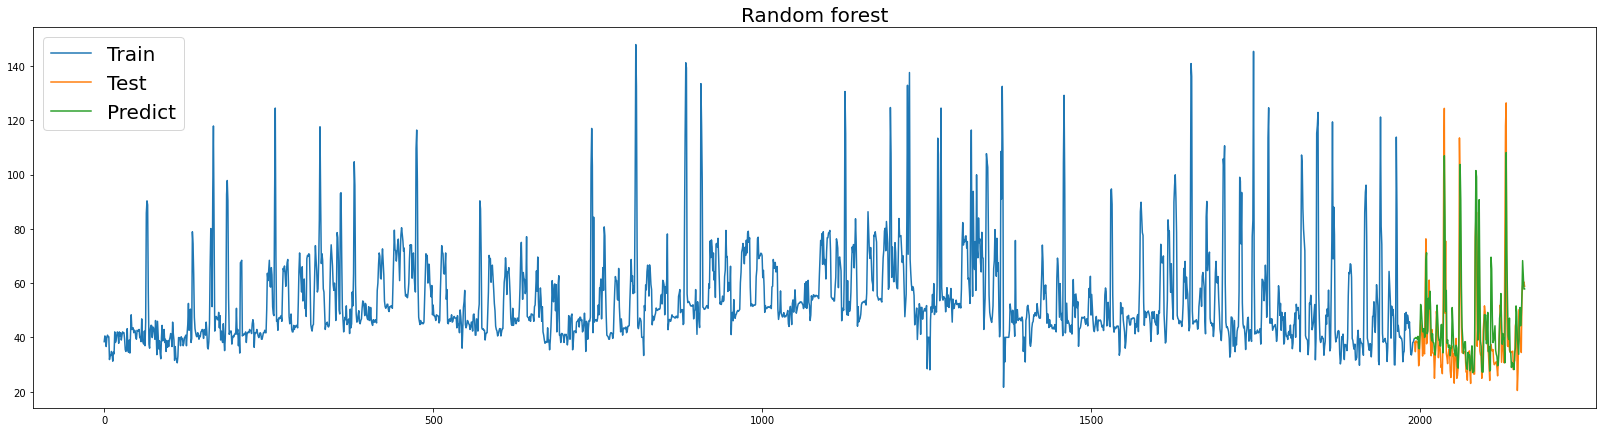

In [ ]:
plt.subplots(figsize=(28,7))
plt.plot(train['Потребитель'].to_frame(), label = 'Train')
plt.plot(test['Потребитель'].to_frame(), label = 'Test')
plt.plot(pred_rf, label = 'Predict')

plt.legend(loc='upper left', fontsize=20)
plt.title("Random forest", fontsize=20)

In [ ]:
df_rmse_rrmse = df_rmse_rrmse.append(pd.DataFrame(data = {'Модель' : 'Random forest', 'RMSE' :
                                     [round(mean_squared_error(y_test, pred_rf, squared=False), 1)],
                                      'MAE' : [round(mean_absolute_error(y_test, pred_rf), 1)] ,
                                      'Промежуток прогнозирования' : 'Неделя', 'Дискретность' : 'Часы',
                                      "Время выполнения, c": [round(time_rf, 2)]}))

### LGBM

In [ ]:
data = pd.read_excel('data_clean.xlsx')
data["hour"] = data['date'].apply(lambda x: x.hour)
data["weekday"] = data['date'].apply(lambda x: x.weekday())

train, test = train_test_split(data, train_size = 1 - 24/len(data), shuffle=False)

In [ ]:
# новый код
start_time = time.time()
temp = train.copy()
temp_4_pred = temp.copy()
front_predict = len(test)
for i in range(front_predict):
# добавили фичи
  temp_4_fit = temp.copy()
  temp_4_fit = feat_eng(feat_eng_1(temp_4_fit))
  temp_4_fit = temp_4_fit.dropna()
  temp_4_fit = temp_4_fit.reset_index(drop=True)
# подготовили иксы и игрики для модели
  X_train_4_fit = temp_4_fit.drop(['Потребитель', 'date'], axis = 1)
  y_train_4_fit = temp_4_fit['Потребитель']
# протренировали модель
  lr = LinearRegression()
  lr.fit(X_train_4_fit, y_train_4_fit)
# создаём следуюущее значение которое надо предсказать
# создадим новую строку, в основном, надо чтобы была добавлена дата на час вперед, остальные знаения будут в нуле
   
  temp_4_pred.loc[len(temp_4_pred), 'date'] = temp_4_pred['date'].iloc[-1] + timedelta(hours=1)
  temp_4_pred.loc[len(temp_4_pred), 'Потребитель'] = np.nan
  temp_4_pred = feat_eng(feat_eng_1(temp_4_pred))
  temp_4_pred = temp_4_pred[:-1]
# на данном этапе имеем датафрейм с одной добавленной строкой и одни пустым значением в искомом столбце
# выделим строку для предсказания
  value_4_pred = temp_4_pred.tail(1)
  X_train_4_pred = value_4_pred.drop(['Потребитель', 'date'], axis = 1)
  X_train_4_pred = X_train_4_pred.fillna(0)
# предсказываем значение
  predict_consumer = lr.predict(X_train_4_pred)
  temp_4_pred.loc[len(temp_4_pred)-1, 'Потребитель'] = float(predict_consumer)
  temp = temp_4_pred.copy()
final = temp_4_pred.copy()  
final = temp_4_pred.copy().loc[len(final)-front_predict:][['date', 'Потребитель']]
time_lr = time.time() - start_time

In [ ]:
start_time = time.time()
temp = train.copy()
temp_4_pred = temp.copy()
front_predict = len(test)
params = {'n_estimators' : list(range(50,105,5)), 'max_depth' : list(range(5,11)), 'min_samples_split' : list(range(2,6)), 'min_samples_leaf' : list(range(1,6))}

temp_4_fit = temp.copy()
temp_4_fit = feat_eng(feat_eng_1(temp_4_fit))
temp_4_fit = temp_4_fit.dropna()
temp_4_fit = temp_4_fit.reset_index(drop=True)
X_train_4_fit = temp_4_fit.drop(['Потребитель', 'date'], axis = 1)
y_train_4_fit = temp_4_fit['Потребитель']

lgbm = LGBMRegressor()

gs_reg = GridSearchCV(lgbm, params, cv = TimeSeriesSplit(n_splits=4).split(X_train_4_fit))
gs_reg.fit(X_train_4_fit, y_train_4_fit)
best_lgb = gs_reg.best_estimator_

temp_4_pred.loc[len(temp_4_pred), 'date'] = temp_4_pred['date'].iloc[-1] + timedelta(hours=1)
temp_4_pred.loc[len(temp_4_pred), 'Потребитель'] = np.nan
temp_4_pred = feat_eng(feat_eng_1(temp_4_pred))
temp_4_pred = temp_4_pred[:-1]

value_4_pred = temp_4_pred.tail(1)
X_train_4_pred = value_4_pred.drop(['Потребитель', 'date'], axis = 1)
X_train_4_pred = X_train_4_pred.fillna(0)

predict_consumer = best_lgb.predict(X_train_4_pred)
temp_4_pred.loc[len(temp_4_pred)-1, 'Потребитель'] = float(predict_consumer)



for i in range(front_predict - 1):

  temp_4_fit = temp.copy()
  temp_4_fit = feat_eng(feat_eng_1(temp_4_fit))
  temp_4_fit = temp_4_fit.dropna()
  temp_4_fit = temp_4_fit.reset_index(drop=True)
  X_train_4_fit = temp_4_fit.drop(['Потребитель', 'date'], axis = 1)
  y_train_4_fit = temp_4_fit['Потребитель']

  best_lgb.fit(X_train_4_fit, y_train_4_fit)

  temp_4_pred.loc[len(temp_4_pred), 'date'] = temp_4_pred['date'].iloc[-1] + timedelta(hours=1)
  temp_4_pred.loc[len(temp_4_pred), 'Потребитель'] = np.nan
  temp_4_pred = feat_eng(feat_eng_1(temp_4_pred))
  temp_4_pred = temp_4_pred[:-1]

  value_4_pred = temp_4_pred.tail(1)
  X_train_4_pred = value_4_pred.drop(['Потребитель', 'date'], axis = 1)
  X_train_4_pred = X_train_4_pred.fillna(0)

  predict_consumer = best_lgb.predict(X_train_4_pred)
  temp_4_pred.loc[len(temp_4_pred)-1, 'Потребитель'] = float(predict_consumer)
  temp = temp_4_pred.copy()
final_lgbm = temp_4_pred.copy()  
final_lgbm = temp_4_pred.copy().loc[len(final_lgbm)-front_predict:][['date', 'Потребитель']]
time_lgbm = time.time() - start_time

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [ ]:
final_lgbm


,date,Потребитель
2136,2022-03-30 01:00:00,44.258304
2137,2022-03-30 02:00:00,44.586199
2138,2022-03-30 03:00:00,44.986124
2139,2022-03-30 04:00:00,44.744443
2140,2022-03-30 05:00:00,44.721185
2141,2022-03-30 06:00:00,44.402006
2142,2022-03-30 07:00:00,43.559310
2143,2022-03-30 08:00:00,43.601612
2144,2022-03-30 09:00:00,43.483210
2145,2022-03-30 10:00:00,44.304290


In [ ]:
start_time = time.time()
temp = train.copy()
y_test = test.copy()
y_test = y_test['Потребитель']
pred_lgbm = y_test.copy()
params = {'n_estimators' : list(range(50,105,5)), 'max_depth' : list(range(5,11)), 'min_samples_split' : list(range(2,6)), 'min_samples_leaf' : list(range(1,6))}

temp_4_fit = temp.copy()
temp_4_fit = feat_eng(feat_eng_1(temp_4_fit))
temp_4_fit = temp_4_fit.dropna()
X_train_4_fit = temp_4_fit.drop(['Потребитель', 'date'], axis = 1)
y_train_4_fit = temp_4_fit['Потребитель']

lgbm = LGBMRegressor()

gs_reg = GridSearchCV(lgbm, params, cv = TimeSeriesSplit(n_splits=4).split(X_train_4_fit))
gs_reg.fit(X_train_4_fit, y_train_4_fit)
best_lgb = gs_reg.best_estimator_

temp.loc[test.index[0]] = test.iloc[0]
temp_4_pred = temp.copy()
temp_4_pred.loc[test.index[0], 'Потребитель'] = np.nan
temp_4_pred = feat_eng(feat_eng_1(temp_4_pred))

temp_4_pred = temp_4_pred.tail(1)
X_train_4_pred = temp_4_pred.drop(['Потребитель','date'], axis = 1)

fitted = best_lgb.predict(X_train_4_pred)
pred_lgbm.loc[pred_lgbm.index[0]] = float(fitted)

for i in range(1,len(test)):

  temp_4_fit = temp.copy()
  temp_4_fit = feat_eng(feat_eng_1(temp_4_fit))
  temp_4_fit = temp_4_fit.dropna()

  X_train_4_fit = temp_4_fit.drop(['Потребитель', 'date'], axis = 1)
  y_train_4_fit = temp_4_fit['Потребитель']

  best_lgb.fit(X_train_4_fit, y_train_4_fit)

  temp.loc[test.index[i]] = test.iloc[i]
  temp_4_pred = temp.copy()
  temp_4_pred.loc[test.index[i], 'Потребитель'] = np.nan
  temp_4_pred = feat_eng(feat_eng_1(temp_4_pred))

  temp_4_pred = temp_4_pred.tail(1)
  X_train_4_pred = temp_4_pred.drop(['Потребитель', 'date'], axis = 1)
  X_train_4_pred = X_train_4_pred.fillna(0)

  fitted = best_lgb.predict(X_train_4_pred)
  pred_lgbm.loc[pred_lgbm.index[i]] = float(fitted)
time_lgbm = time.time() - start_time

In [ ]:
best_lgb

LGBMRegressor(max_depth=5, min_samples_leaf=1, min_samples_split=2,
              n_estimators=50)

Text(0.5, 1.0, 'LGBM')

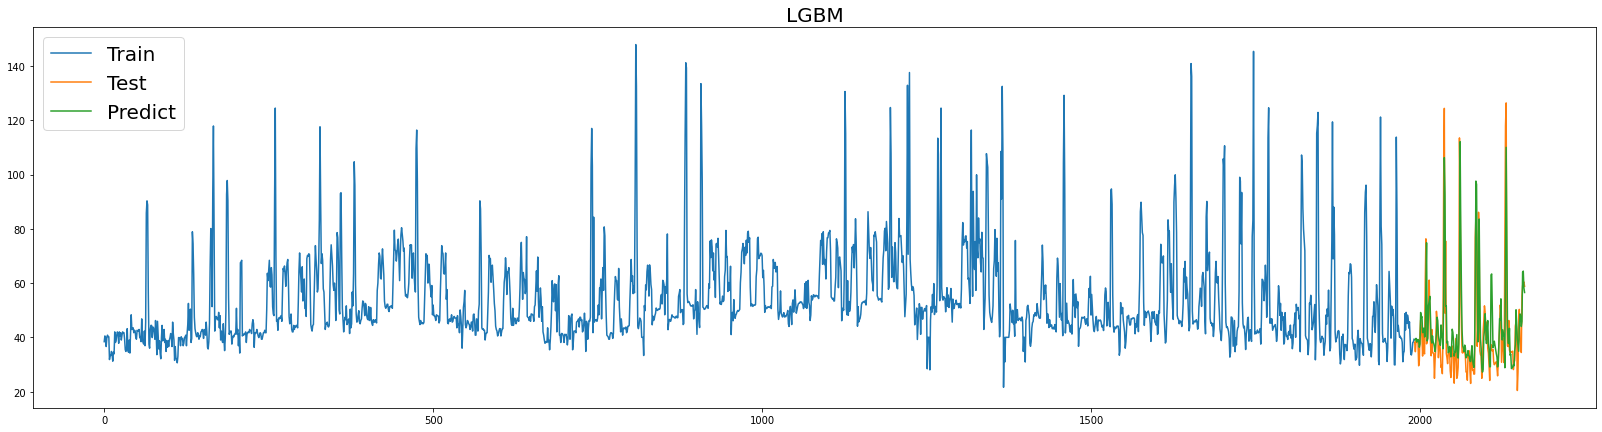

In [ ]:
plt.subplots(figsize=(28,7))
plt.plot(train['Потребитель'].to_frame(), label = 'Train')
plt.plot(test['Потребитель'].to_frame(), label = 'Test')
plt.plot(pred_lgbm, label = 'Predict')

plt.legend(loc='upper left', fontsize=20)
plt.title("LGBM", fontsize=20)

In [ ]:
df_rmse_rrmse = df_rmse_rrmse.append(pd.DataFrame(data = {'Модель' : 'LGBM', 'RMSE' :
                                     [round(mean_squared_error(y_test, pred_lgbm, squared=False), 1)],
                                      'MAE' : [round(mean_absolute_error(y_test, pred_lgbm), 1)] ,
                                      'Промежуток прогнозирования' : 'Неделя', 'Дискретность' : 'Часы',
                                      "Время выполнения, c": [round(time_lgbm, 2)]}))

Посмотрим на отонсительную важность фич

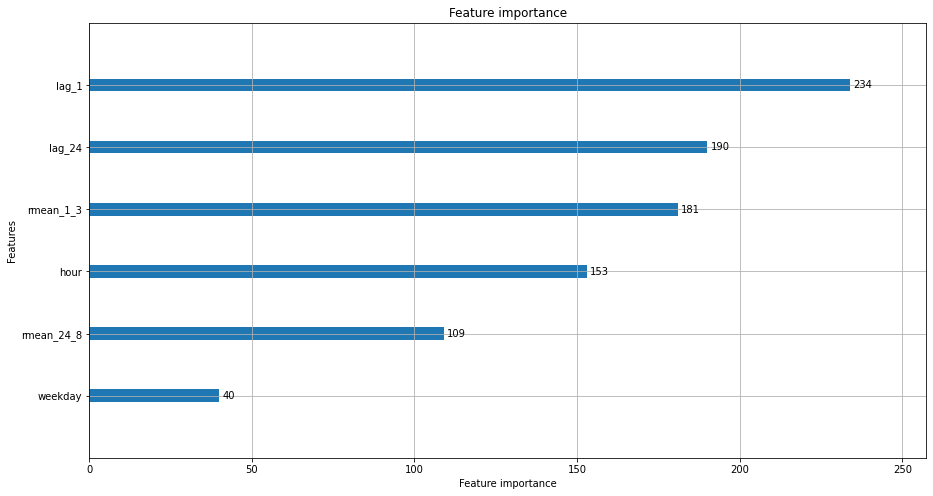

In [ ]:
lgb.plot_importance(best_lgb, figsize=(15, 8))

Как видим почти все фичи, кроме дня недели имеют относительно высокую "важность".

### Catboost

In [ ]:
start_time = time.time()
temp = train.copy()
y_test = test.copy()
y_test = y_test['Потребитель']
pred_catboost = y_test.copy()
params = {'n_estimators' : list(range(50,105,5)), 'max_depth' : list(range(5,11))}

temp_4_fit = temp.copy()
temp_4_fit = feat_eng(feat_eng_1(temp_4_fit))
temp_4_fit = temp_4_fit.dropna()
X_train_4_fit = temp_4_fit.drop(['Потребитель', 'date'], axis = 1)
y_train_4_fit = temp_4_fit['Потребитель']

Catbooster = CatBoostRegressor(random_state=123, silent=True)

gs_reg = GridSearchCV(Catbooster, params, cv = TimeSeriesSplit(n_splits=4).split(X_train_4_fit))
gs_reg.fit(X_train_4_fit, y_train_4_fit)
best_catboost = gs_reg.best_estimator_

temp.loc[test.index[0]] = test.iloc[0]
temp_4_pred = temp.copy()
temp_4_pred.loc[test.index[0], 'Потребитель'] = np.nan
temp_4_pred = feat_eng(feat_eng_1(temp_4_pred))

temp_4_pred = temp_4_pred.tail(1)
X_train_4_pred = temp_4_pred.drop(['Потребитель','date'], axis = 1)

fitted = best_catboost.predict(X_train_4_pred)
pred_catboost.loc[pred_catboost.index[0]] = float(fitted)

for i in range(1,len(test)):

  temp_4_fit = temp.copy()
  temp_4_fit = feat_eng(feat_eng_1(temp_4_fit))
  temp_4_fit = temp_4_fit.dropna()

  X_train_4_fit = temp_4_fit.drop(['Потребитель', 'date'], axis = 1)
  y_train_4_fit = temp_4_fit['Потребитель']

  best_catboost.fit(X_train_4_fit, y_train_4_fit)

  temp.loc[test.index[i]] = test.iloc[i]
  temp_4_pred = temp.copy()
  temp_4_pred.loc[test.index[i], 'Потребитель'] = np.nan
  temp_4_pred = feat_eng(feat_eng_1(temp_4_pred))

  temp_4_pred = temp_4_pred.tail(1)
  X_train_4_pred = temp_4_pred.drop(['Потребитель', 'date'], axis = 1)
  X_train_4_pred = X_train_4_pred.fillna(0)

  fitted = best_catboost.predict(X_train_4_pred)
  pred_catboost.loc[pred_catboost.index[i]] = float(fitted)
time_cb = time.time() - start_time

In [ ]:
best_catboost

Text(0.5, 1.0, 'catboost')

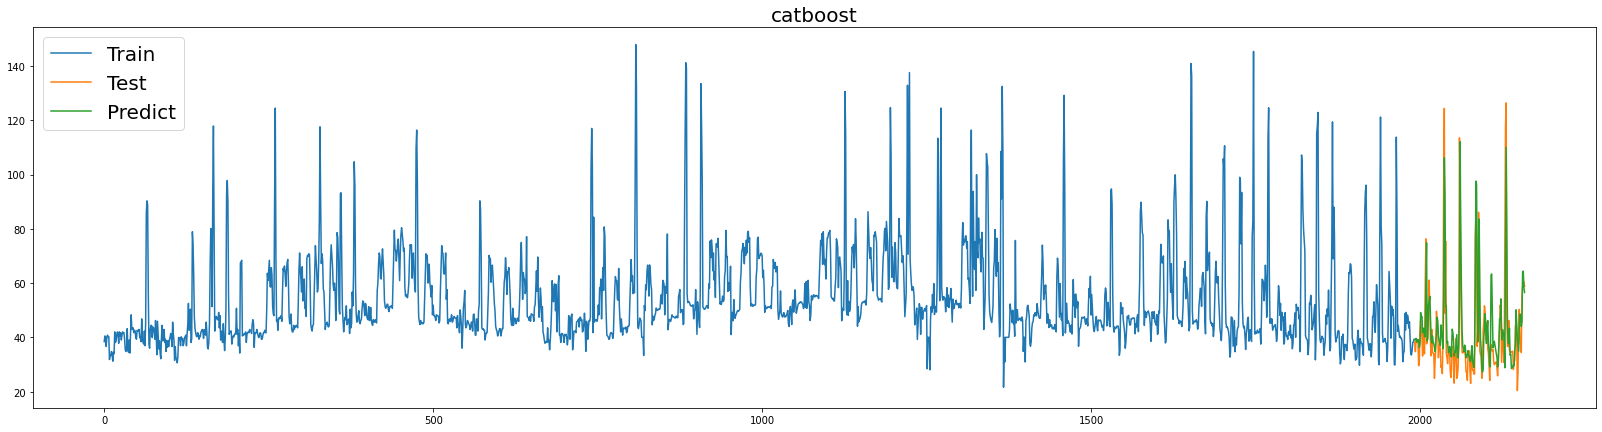

In [ ]:
plt.subplots(figsize=(28,7))
plt.plot(train['Потребитель'].to_frame(), label = 'Train')
plt.plot(test['Потребитель'].to_frame(), label = 'Test')
plt.plot(pred_lgbm, label = 'Predict')

plt.legend(loc='upper left', fontsize=20)
plt.title("catboost", fontsize=20)

In [ ]:
df_rmse_rrmse = df_rmse_rrmse.append(pd.DataFrame(data = {'Модель' : 'CatBoost', 'RMSE' :
                                     [round(mean_squared_error(y_test, pred_catboost, squared=False), 1)],
                                      'MAE' : [round(mean_absolute_error(y_test, pred_catboost), 1)] ,
                                      'Промежуток прогнозирования' : 'Неделя', 'Дискретность' : 'Часы',
                                      "Время выполнения, c": [round(time_cb, 2)]}))

## Результаты моделей ML

In [ ]:
df_rmse_rrmse

,Модель,RMSE,MAE,Промежуток прогнозирования,Дискретность,"Время выполнения, c"
0,Linear Regression,14.6,9.4,Неделя,Часы,8.73
0,Random forest,12.9,8.5,Неделя,Часы,1351.02
0,LGBM,13.0,8.4,Неделя,Часы,283.36
0,CatBoost,12.8,8.1,Неделя,Часы,167.24


Ссылки на блокноты по похожему прогнозированию

https://www.cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost.html

https://www.cienciadedatos.net/documentos/py29-forecasting-electricity-power-demand-python.html

## Library Greykite

В данном разделе будет представлена возможность библиотеки по анализу и прогнозированию временных рядов Greykite

Ссылки на источники:
https://medium.com/geekculture/greykite-the-new-forecasting-library-from-linkedin-case-bitcoin-price-prediction-981d21e79b31


В первую очередь необходимо установить библиотеку

In [ ]:
!pip install greykite

In [ ]:
from collections import defaultdict
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import plotly
from greykite.framework.input.univariate_time_series import UnivariateTimeSeries
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.forecaster import Forecaster
from greykite.framework.templates.model_templates import ModelTemplateEnum
from greykite.framework.utils.result_summary import summarize_grid_search_results

In [ ]:
# загрузка данных
data = pd.read_excel('data_clean.xlsx')
data.head()

,date,Потребитель
0,2022-01-01 01:00:00,38.4
1,2022-01-01 02:00:00,40.5
2,2022-01-01 03:00:00,40.2
3,2022-01-01 04:00:00,36.6
4,2022-01-01 05:00:00,39.9


#### возможности greykite

In [ ]:
# Преобразование в требуемый формат, описание данных и построение графика
ts = UnivariateTimeSeries()
ts.load_data(
    df=data,
    time_col="date",
    value_col="Потребитель",
    freq="H")

print(ts.describe_time_col())
print(ts.describe_value_col())

fig = ts.plot()
plotly.io.show(fig)

{'data_points': 2160, 'mean_increment_secs': 3600.0, 'min_timestamp': Timestamp('2022-01-01 01:00:00'), 'max_timestamp': Timestamp('2022-04-01 00:00:00')}
count    2160.000000
mean       52.831620
std        17.061865
min        20.400000
25%        42.200000
50%        48.000860
75%        59.100000
max       147.902648
Name: y, dtype: float64


#### Greykite предсказание

In [ ]:
# создание модели для предсказания на неделю вперед
metadata = MetadataParam(
    time_col="date",
    value_col="Потребитель",
    freq="H"  # "H" for hourly, "D" for daily, "W" for weekly, etc.
)

forecaster = Forecaster()
result = forecaster.run_forecast_config(
    df=data,
    config=ForecastConfig(
        model_template=ModelTemplateEnum.SILVERKITE.name,
        forecast_horizon=7*24,  # Предсказание на 15%
        coverage=0.95,  # 95% prediction intervals
        metadata_param=metadata))

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [ ]:
grid_search = result.grid_search
cv_results = summarize_grid_search_results(
 grid_search=grid_search,
 decimals=4,
 cv_report_metrics=None,
 column_order=["rank", "mean_test", "split_test", "mean_train", "split_train", "mean_fit_time", "mean_score_time", "params"])
cv_results["params"] = cv_results["params"].astype(str)
cv_results.set_index("params", drop=True, inplace=True)
cv_results.transpose()

params,[]
rank_test_MAPE,1
mean_test_MAPE,23.6431
split_test_MAPE,"(14.5813, 23.5185, 32.8294)"
mean_train_MAPE,19.0894
split_train_MAPE,"(21.1678, 17.9417, 18.1588)"
mean_fit_time,28.5667
mean_score_time,1.1617


In [ ]:
 backtest = result.backtest
 fig = backtest.plot()
 plotly.io.show(fig)

In [ ]:
 backtest_eval = defaultdict(list)
 for metric, value in backtest.train_evaluation.items():
     backtest_eval[metric].append(value)
     backtest_eval[metric].append(backtest.test_evaluation[metric])
 metrics = pd.DataFrame(backtest_eval, index=["train", "test"]).T
 metrics

,train,test
CORR,0.449701,0.447888
R2,0.1847,-0.350282
MSE,224.129715,456.881585
RMSE,14.970962,21.374789
MAE,10.362645,19.255214
MedAE,7.674837,19.050051
MAPE,19.005472,53.377046
MedAPE,15.453144,49.356568
sMAPE,9.170883,20.748213
Q80,5.181323,5.642655


Вывод по greykite: как и библиотека etna, которую я решил не прикреплять на данный момент является инструментом для анализа временного ряда, по поводу прогнозирования, у greykite есть две коробчатые функции, одна из них построена и результат хуже чем линейные модели. У etna просто собраны в одном месте много моделей, но столкнулся с проблемой прогнозирования, функция которая делает признаки ломанная.

## PROPHET

Применение библиотеки prophet.

In [ ]:
!pip install prophet

In [ ]:
import pandas as pd
from prophet import Prophet

In [ ]:
# исходные данные 
df = pd.read_excel('data_clean.xlsx')
df.head()

,date,Потребитель
0,2022-01-01 01:00:00,38.4
1,2022-01-01 02:00:00,40.5
2,2022-01-01 03:00:00,40.2
3,2022-01-01 04:00:00,36.6
4,2022-01-01 05:00:00,39.9


In [ ]:
train_pr, test_pr = train_test_split(df, train_size = 1 - 7*24/len(data), shuffle=False)

Преобразование данных в требуемый формат

In [ ]:
data = train_pr[['date','Потребитель']]
data.dropna(inplace=True)
data.columns = ['ds', 'y'] 
data

,ds,y
0,2022-01-01 01:00:00,38.4
1,2022-01-01 02:00:00,40.5
2,2022-01-01 03:00:00,40.2
3,2022-01-01 04:00:00,36.6
4,2022-01-01 05:00:00,39.9
...,...,...
1987,2022-03-24 20:00:00,33.5
1988,2022-03-24 21:00:00,35.0
1989,2022-03-24 22:00:00,38.1
1990,2022-03-24 23:00:00,38.3


создание и тренировка модели

In [ ]:
m = Prophet()
m.fit(data)

20:51:50 - cmdstanpy - INFO - Chain [1] start processing
20:51:51 - cmdstanpy - INFO - Chain [1] done processing


Создание горизонта прогнозирования

In [ ]:
future = m.make_future_dataframe(periods=7*24, freq = 'H')
future.head()

,ds
0,2022-01-01 01:00:00
1,2022-01-01 02:00:00
2,2022-01-01 03:00:00
3,2022-01-01 04:00:00
4,2022-01-01 05:00:00


Непосредственно предсказание 

In [ ]:
start_time = time.time()
forecast = m.predict(future)
time_proph = time.time() - start_time
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
2155,2022-03-31 20:00:00,55.358146,35.686369,74.006916
2156,2022-03-31 21:00:00,58.622037,40.891353,77.875596
2157,2022-03-31 22:00:00,57.980497,39.966369,75.895384
2158,2022-03-31 23:00:00,53.400527,34.478225,73.548077
2159,2022-04-01 00:00:00,47.501520,28.103850,67.205426


In [ ]:
forecast['yhat'].iloc[-24*7:]
print('MAE:', mean_absolute_error(test_pr['Потребитель'], forecast['yhat'].iloc[-24*7:]))
print('RMSE:', mean_squared_error(test_pr['Потребитель'], forecast['yhat'].iloc[-24*7:], squared=False))

MAE: 12.370113576319538
RMSE: 17.23371695364307


In [ ]:
df_rmse_rrmse = df_rmse_rrmse.append(pd.DataFrame(data = {'Модель' : 'Prophet', 'RMSE' :
                                     [round(mean_squared_error(test_pr['Потребитель'], forecast['yhat'].iloc[-24*7:], squared=False), 1)],
                                      'MAE' : [round(mean_absolute_error(test_pr['Потребитель'], forecast['yhat'].iloc[-24*7:]), 1)] ,
                                      'Промежуток прогнозирования' : 'Неделя', 'Дискретность' : 'Часы',
                                      "Время выполнения, c": [round(time_proph, 2)]}))

Графика через раз строится, по поводу того, можно ли эти модные точки соединить, ответ к сожалению без переопределения внутренних функций и возьни с кодом нет, считаю что не стоит тратить время на это.

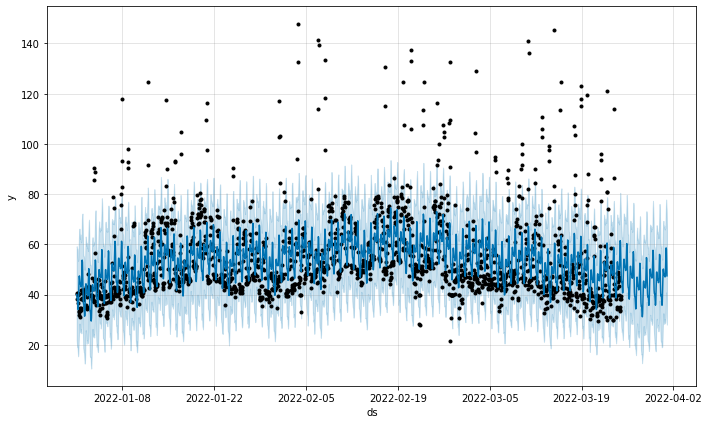

In [ ]:
fig1 = m.plot(forecast)

# Подведение итогов

In [ ]:
df_rmse_rrmse

NameError: ignored